<a href="https://colab.research.google.com/github/mahmoudelhout86/Customer_Loyality_DEPI_SHR2_AIS4_G1/blob/master/elo_merchant_transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c elo-merchant-category-recommendation

In [ ]:
!unzip elo-merchant-category-recommendation.zip

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Importing Libraries</b>

In [ ]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import statistics
from sklearn.preprocessing import OneHotEncoder

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Defining Functions</b>

In [ ]:
def IQROutlierCheck(df, col):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q1 + 1.5 * IQR
    critic_score_outliers = df[(df[col] < lower) | (df[col] > upper)]

    return critic_score_outliers

In [ ]:
def OutliersInfo(df, cols):

    outlier_dict=dict()
    for col in cols:
        print(f"\n{col}")
        print("-"*35)
        critic_outliers = IQROutlierCheck(df, col)
        outlier_dict[col] = critic_outliers.index
        print(f"Number of outlier samples produced by IQR is {critic_outliers[col].shape[0]}")
        for i in range(0, 2):

            print("{}% percentile value is {:3.3f}".format(i, np.percentile(df[col], i)))
        for i in range(98, 101):
            print("{}% percentile value is {:3.3f}".format(i, np.percentile(df[col], i)))

        percent = np.percentile(df[col], 1)
        count = len(df[df[col]<percent])
        print(f"\n\t- Number of values less than {percent} is {count}")
        percent = np.percentile(df[col], 99)
        count = len(df[df[col]>percent])
        print(f"\t- Number of values greater than {percent} is {count}")

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Reading and Combining Transactions Dataset</b>

In [ ]:
# Define data types for each column to reduce memory usage
dtypes = {
    'card_id': 'category',
    'merchant_id': 'category',
    'month_lag': 'int8',
    'authorized_flag': 'category',
    'category_1': 'category',
    'installments': 'int16',
    'purchase_amount': 'float32',
    'city_id': 'int16',
    'state_id': 'int8',
    'subsector_id': 'int8',
    'merchant_category_id': 'int16',
    'category_2': 'float32',
    'category_3': 'category'
}


In [ ]:
# Define chunk size
chunk_size = 500000

# Initialize lists to store chunks
history_chunks = []
new_merchant_chunks = []

# Read historical transactions in chunks
for chunk in pd.read_csv('/content/historical_transactions.csv', chunksize=chunk_size, dtype=dtypes):
    history_chunks.append(chunk)

# Read new merchant transactions in chunks
for chunk in pd.read_csv('/content/new_merchant_transactions.csv', chunksize=chunk_size, dtype=dtypes):
    new_merchant_chunks.append(chunk)

# Combine all chunks from both datasets
combined_transactions = pd.concat(history_chunks + new_merchant_chunks, axis=0)

# Clean up memory
del history_chunks, new_merchant_chunks
gc.collect()

print(combined_transactions.shape)

(31075392, 14)


In [ ]:
# Displaying the first 5 rows of the combined transactions

combined_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [ ]:
# Summary of combined transactions DataFrame including data types, non-null counts, and memory usage

combined_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31075392 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Dtype   
---  ------                -----   
 0   authorized_flag       object  
 1   card_id               object  
 2   city_id               int16   
 3   category_1            category
 4   installments          int16   
 5   category_3            category
 6   merchant_category_id  int16   
 7   merchant_id           object  
 8   month_lag             int8    
 9   purchase_amount       float32 
 10  purchase_date         object  
 11  category_2            float32 
 12  state_id              int8    
 13  subsector_id          int8    
dtypes: category(2), float32(2), int16(3), int8(3), object(4)
memory usage: 1.7+ GB


<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Handling Missing Values</b>

In [ ]:
# Check for missing values in the combined transactions

combined_transactions.isnull().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               234081
merchant_category_id          0
merchant_id              164697
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2764609
state_id                      0
subsector_id                  0
dtype: int64

In [ ]:
# Calculating and Printing the Mode for 'Category_2', 'Category_3', and 'Merchant_id' columns

category_2_mode = combined_transactions['category_2'].mode()[0]
category_3_mode = combined_transactions['category_3'].mode()[0]
merchant_id_mode = combined_transactions['merchant_id'].mode()[0]

print(f"Most Common in category_2 : {category_2_mode}")
print(f"Most Common in category_3 : {category_3_mode}")
print(f"Most Common in merchant_id : {merchant_id_mode}")

Most Common in category_2 : 1.0
Most Common in category_3 : A
Most Common in merchant_id : M_ID_00a6ca8a8a


In [ ]:
# Fill the missing values in 'mercahnt_id', 'category_2', and 'category_3' columns

combined_transactions['merchant_id'].fillna(merchant_id_mode, inplace=True)
combined_transactions['category_3'].fillna(category_3_mode, inplace=True)
combined_transactions['category_2'].fillna(category_2_mode, inplace=True)

<ipython-input-16-09e4dc49ab4c>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_transactions['merchant_id'].fillna(merchant_id_mode, inplace=True)
<ipython-input-16-09e4dc49ab4c>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

In [ ]:
# Check for missing values in combined transactions after filling them

combined_transactions.isnull().sum()

authorized_flag         0
card_id                 0
city_id                 0
category_1              0
installments            0
category_3              0
merchant_category_id    0
merchant_id             0
month_lag               0
purchase_amount         0
purchase_date           0
category_2              0
state_id                0
subsector_id            0
dtype: int64

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Handling Duplicated Values</b>

In [ ]:
# Check for duplicate rows in combined transactions

combined_transactions.duplicated().sum()

0

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Handling Outliers</b>

In [ ]:
# Generate descriptive statistics for numerical columns in combined transactions

combined_transactions.describe().T

,count,mean,std,min,25%,50%,75%,max
city_id,31075392.0,129.645324,104.092565,-1.000000,53.000000,90.000000,212.000000,347.0
installments,31075392.0,0.650673,2.734985,-1.000000,0.000000,0.000000,1.000000,999.0
merchant_category_id,31075392.0,477.851821,249.482143,-1.000000,302.000000,454.000000,705.000000,891.0
month_lag,31075392.0,-4.110560,3.766495,-13.000000,-7.000000,-3.000000,-1.000000,2.0
purchase_amount,31075392.0,-0.000703,1087.456055,-0.746908,-0.719905,-0.687523,-0.600865,6010604.0
category_2,31075392.0,2.088498,1.449610,1.000000,1.000000,1.000000,3.000000,5.0
state_id,31075392.0,10.586618,6.347145,-1.000000,9.000000,9.000000,16.000000,24.0
subsector_id,31075392.0,26.793295,9.723248,-1.000000,19.000000,29.000000,34.000000,41.0


In [ ]:
# Display information about outliers

col = ['installments', 'month_lag', 'purchase_amount','category_2']
OutliersInfo(combined_transactions, col)


installments
-----------------------------------
Number of outlier samples produced by IQR is 1993620
0% percentile value is -1.000
1% percentile value is 0.000
98% percentile value is 4.000
99% percentile value is 6.000
100% percentile value is 999.000

	- Number of values less than 0.0 is 234081
	- Number of values greater than 6.0 is 226769

month_lag
-----------------------------------
Number of outlier samples produced by IQR is 0
0% percentile value is -13.000
1% percentile value is -13.000
98% percentile value is 2.000
99% percentile value is 2.000
100% percentile value is 2.000

	- Number of values less than -13.0 is 0
	- Number of values greater than 2.0 is 0

purchase_amount
-----------------------------------
Number of outlier samples produced by IQR is 5371881
0% percentile value is -0.747
1% percentile value is -0.743
98% percentile value is 0.455
99% percentile value is 1.240
100% percentile value is 6010604.000

	- Number of values less than -0.7431662082672119 is 30813

In [ ]:
# Count unique value in 'installments' column

combined_transactions['installments'].value_counts()

installments
 0      16333991
 1      12513700
 2        721145
 3        582957
-1        234081
 4        194340
 6        143023
 10       127726
 5        125386
 12        57914
 8         22029
 7         11769
 9          6250
 11          891
 999         190
Name: count, dtype: int64

In [ ]:
# Count the number of rows where 'purchase_amount' is greater than 2

combined_transactions[combined_transactions['purchase_amount'] > 2].count()

authorized_flag         188122
card_id                 188122
city_id                 188122
category_1              188122
installments            188122
category_3              188122
merchant_category_id    188122
merchant_id             188122
month_lag               188122
purchase_amount         188122
purchase_date           188122
category_2              188122
state_id                188122
subsector_id            188122
dtype: int64

In [ ]:
# Drop the rows where 'purchase_amount' is greater than 2

combined_transactions = combined_transactions.drop(combined_transactions[combined_transactions['purchase_amount'] > 2].index)
combined_transactions.shape

(30865318, 14)

In [ ]:
# Drop rows where 'installments' is -1 or 999

Remove_Values = [-1,999]
combined_transactions = combined_transactions[~combined_transactions['installments'].isin(Remove_Values)]
combined_transactions.shape

(30643103, 14)

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Handling Data Formatting</b>

In [ ]:
# Convert the 'Purchase_date' column to datatime Type

combined_transactions['purchase_date']  = pd.to_datetime(combined_transactions['purchase_date'], format='%Y-%m-%d %H:%M:%S')

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:160%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400;
            text-align:
            center;"><b>Visualization</b>

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Create function for categorical features</b>

In [ ]:
colors = sns.cubehelix_palette(20,reverse = True, light= 0.01,dark = 0.5, gamma= 0.7)
palette_color  = sns.color_palette("RdBu",10)
sns.set_theme(style="whitegrid", palette=palette_color)

def bar_plot(counts, column, ax, orient='v'):

    if orient=='h':
        x_col = 'count'
        y_col = column
    else:
        x_col = column
        y_col = 'count'

    sns.barplot(data = counts, x=x_col, y=y_col, ax=ax, orient=orient)


    if orient == 'v':
        # Annotate each bar with its height (number of occurrences)
        for p in ax.patches:
            x_coor = p.get_x() + 0.5 * p.get_width()
            y_coor = p.get_height()
            hight = int(p.get_height())

            ax.annotate(hight,            # Text to be displayed (converted to int for formatting)
                        (x_coor, y_coor), # Coordinates of the annotation (x, y)
                        ha='center',      # Horizontal alignment of the text ('center' aligns it at the center of the x-coordinate)
                        va='bottom',      # Vertical alignment of the text ('bottom' aligns it at the bottom of the bar)
                        color='black'     # Color of the text
                        )
        ax.set_xlabel(column, weight = "bold",  fontsize = 14, labelpad = 20)
        ax.set_ylabel('Number of Occurrences', weight = "bold", fontsize = 14, labelpad = 20)

    ax.tick_params(axis = 'both', labelsize = 12)

    return ax

In [ ]:
def plot_categorical_feature(counts, figsize=(12,5)):
   column = counts.columns[0]

   # Create a figure with two subplots
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

   # Bar chart
   bar_plot(counts, column, ax1)

   # Pie chart
   ax2.pie(counts['count'], labels=counts[column], autopct = '%1.1f%%')
   ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
   ax2.legend(counts[column], loc="best") # Add legned with labels

   # Adjust layout
   plt.suptitle(f'Distribution of {column}', weight = "bold", fontsize = 16)
   plt.tight_layout()
   plt.show()

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Distribution of Authorized Flag</b>

In [ ]:
authorized_flag_counts = combined_transactions['authorized_flag'].value_counts().reset_index()
authorized_flag_counts

,authorized_flag,count
0,Y,28196898
1,N,2446205


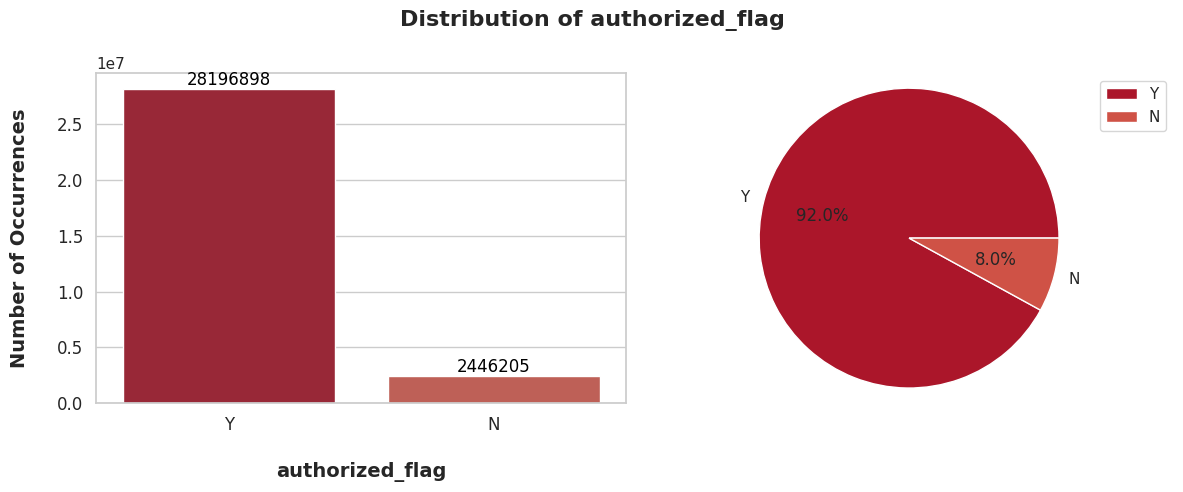

In [ ]:
plot_categorical_feature(authorized_flag_counts)

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Top 25 Card ID</b>

In [ ]:
Card_ID_Counts = combined_transactions['card_id'].value_counts().head(25).sort_values().reset_index()
Card_ID_Counts

,card_id,count
0,C_ID_d15ffb9f61,1380
1,C_ID_94cf87a008,1408
2,C_ID_4d3a26f711,1415
3,C_ID_003e56029c,1426
4,C_ID_89d1b0c84e,1434
5,C_ID_f028f3b41c,1443
6,C_ID_62698b6025,1451
7,C_ID_fef34cc0a0,1455
8,C_ID_7dca81e0f1,1461
9,C_ID_66197df71f,1476


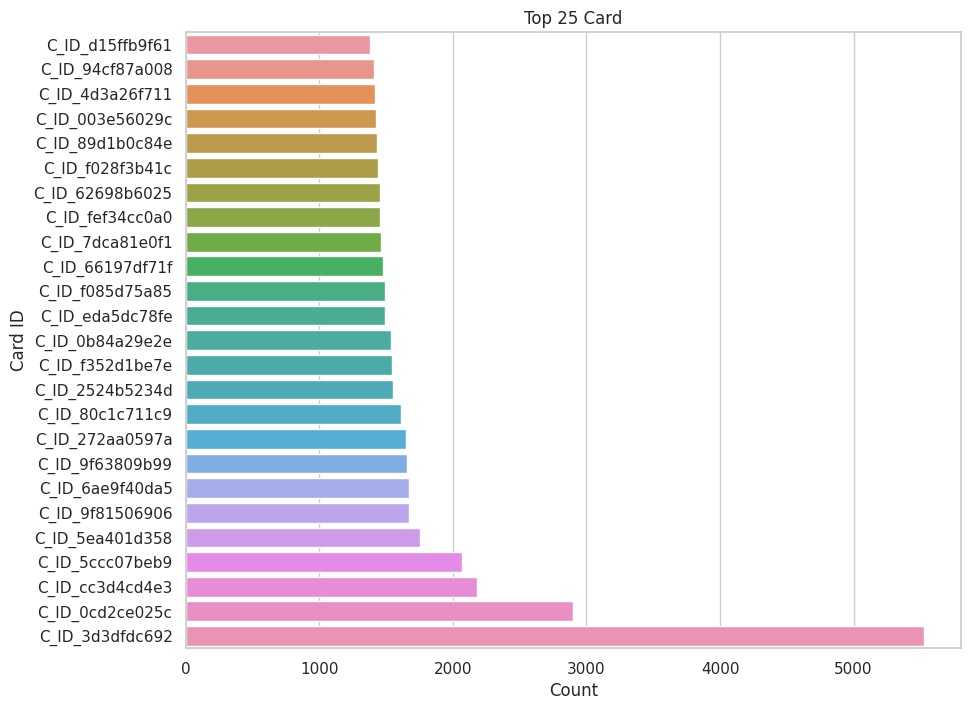

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(data=Card_ID_Counts,x='count',y='card_id' ,orient='h')
plt.title('Top 25 Card')
plt.xlabel('Count')
plt.ylabel('Card ID')
plt.show()

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Top 25 Merchant ID</b>

In [ ]:
Merchant_ID_Counts = combined_transactions['merchant_id'].value_counts().head(25).sort_values().reset_index()
Merchant_ID_Counts

,merchant_id,count
0,M_ID_b5b80addf5,47136
1,M_ID_820c7b73c8,49302
2,M_ID_a9d91682ad,49831
3,M_ID_3111c6df35,51543
4,M_ID_c03b62d83d,53073
5,M_ID_940fb4498f,53307
6,M_ID_82a30d9203,67641
7,M_ID_2637773dd2,69581
8,M_ID_445742726b,69881
9,M_ID_b98db225f5,72200


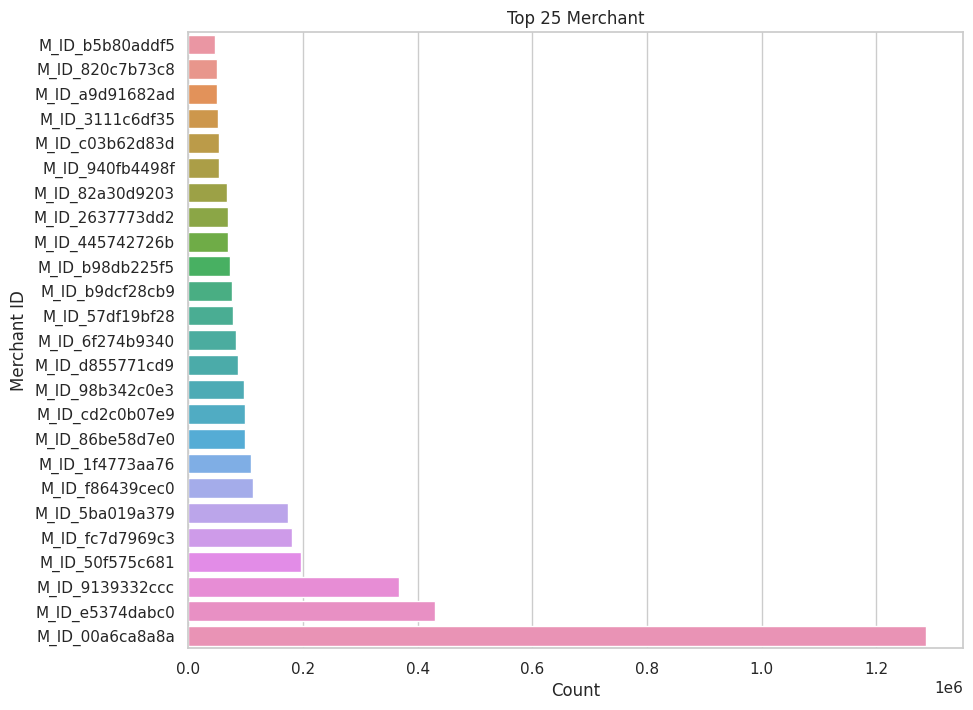

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(data=Merchant_ID_Counts,x='count',y='merchant_id' ,orient='h')
plt.title('Top 25 Merchant')
plt.xlabel('Count')
plt.ylabel('Merchant ID')
plt.show()

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Distribution of Category 1</b>

In [ ]:
Category_1_Counts = combined_transactions['category_1'].value_counts().reset_index()
Category_1_Counts

,category_1,count
0,N,28543512
1,Y,2099591


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


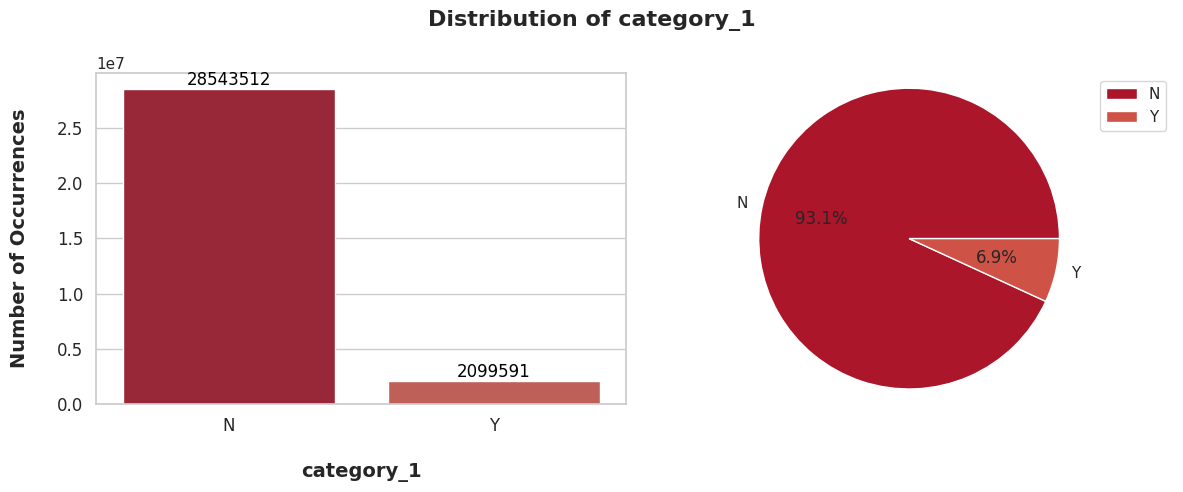

In [ ]:
plot_categorical_feature(Category_1_Counts)

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Distribution of Installments</b>

In [ ]:
Installments_Counts = combined_transactions['installments'].value_counts().reset_index()
Installments_Counts

,installments,count
0,0,16290964
1,1,12464940
2,2,714200
3,3,566156
4,4,182492
5,6,126253
6,5,115929
7,10,100192
8,12,47458
9,8,18109


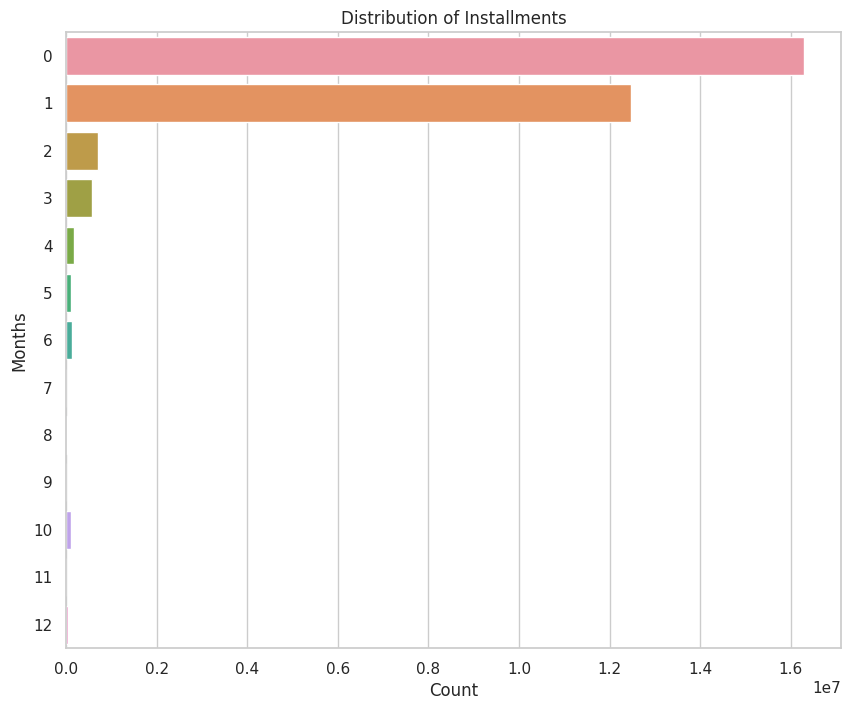

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(data=Installments_Counts,x='count',y='installments' ,orient='h')
plt.title('Distribution of Installments')
plt.xlabel('Count')
plt.ylabel('Months')
plt.show()

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Distribution of Category 3</b>

In [ ]:
Category_3_Counts = combined_transactions['category_3'].value_counts().reset_index()
Category_3_Counts

,category_3,count
0,A,16290964
1,B,12464940
2,C,1887199


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


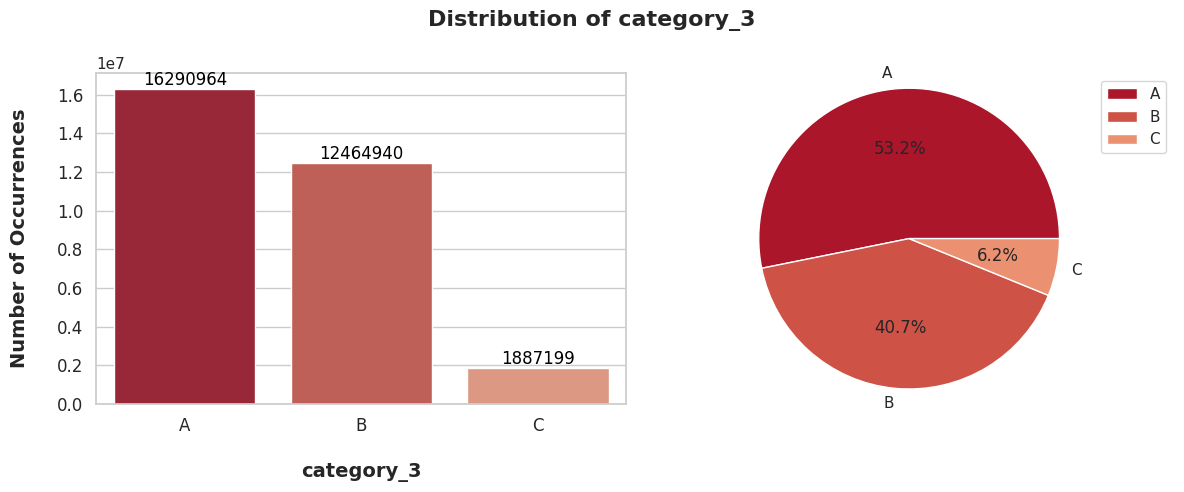

In [ ]:
plot_categorical_feature(Category_3_Counts)

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Distribution of Month Lag</b>

In [ ]:
Month_Lag_Counts = combined_transactions['month_lag'].value_counts().reset_index()
Month_Lag_Counts

,month_lag,count
0,-2,3786586
1,-1,3562431
2,0,3408883
3,-3,3047080
4,-4,2611595
5,-5,2348707
6,-6,2036019
7,-7,1757996
8,-8,1418493
9,-9,1226499


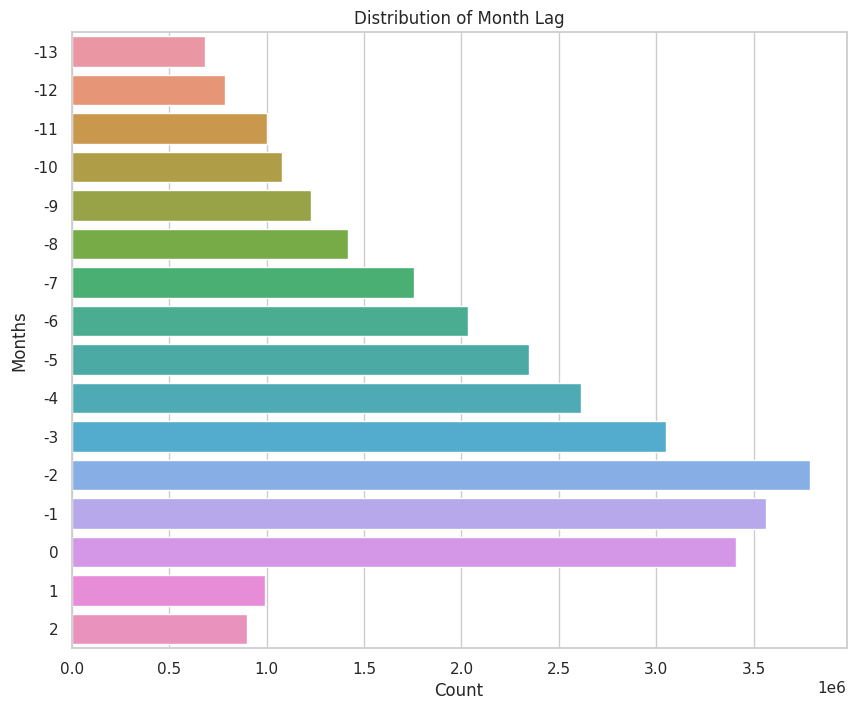

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(data=Month_Lag_Counts,x='count',y='month_lag' ,orient='h')
plt.title('Distribution of Month Lag')
plt.xlabel('Count')
plt.ylabel('Months')
plt.show()

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Distribution of Category 2</b>

In [ ]:
Category_2_Counts = combined_transactions['category_2'].value_counts().reset_index()
Category_2_Counts

,category_2,count
0,1.0,18746777
1,3.0,4117058
2,5.0,3931745
3,4.0,2767160
4,2.0,1080363


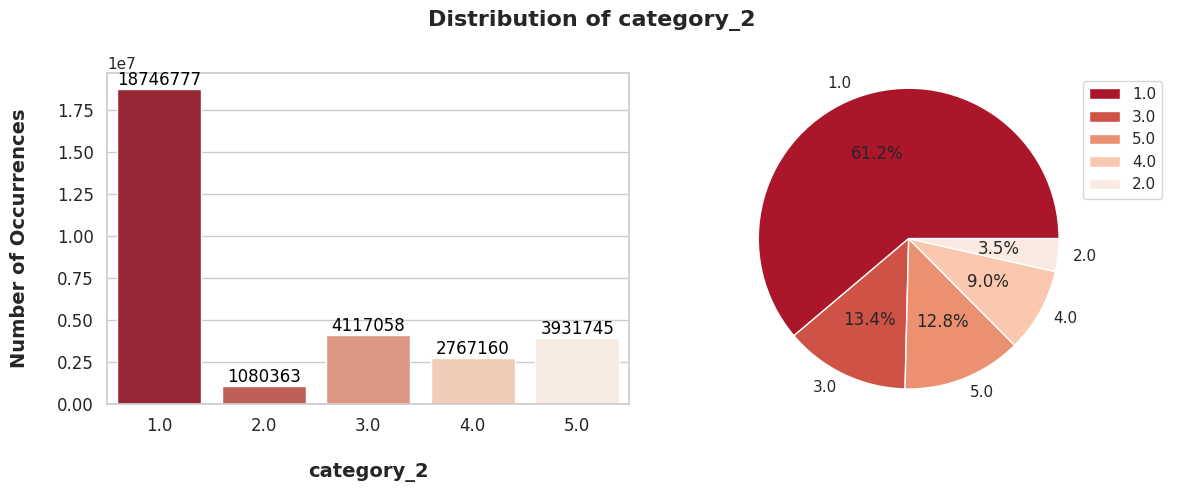

In [ ]:
plot_categorical_feature(Category_2_Counts)

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Distribution of Top 25 Card Purchased</b>

In [ ]:
grouped = combined_transactions.groupby('card_id')['purchase_amount'].sum().reset_index().sort_values(by='purchase_amount',ascending=False).head(25)
grouped

,card_id,purchase_amount
119677,C_ID_5e10990e53,395.151062
223478,C_ID_afb41d5dd8,201.942871
39728,C_ID_1f2da5cd9a,165.635849
44239,C_ID_22b6ce9ce6,165.187149
64085,C_ID_3246e29804,159.564209
33565,C_ID_1a709fcde4,153.927322
169301,C_ID_852d2144a6,153.654770
280815,C_ID_dd09c33e07,149.950912
24329,C_ID_1335033ea7,141.614929
321977,C_ID_fd3fe00d69,121.646904


In [ ]:
top_25_card_Purchased = grouped['card_id'].tolist()
filtered_trans = combined_transactions[combined_transactions['card_id'].isin(top_25_card_Purchased)]
filtered_trans

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
310067,Y,C_ID_3246e29804,88,N,2,C,45,M_ID_8ad723eae8,-6,0.485266,2017-03-06 20:19:16,1.0,16,18
310068,N,C_ID_3246e29804,88,N,2,C,373,M_ID_8ad723eae8,-2,0.602473,2017-07-19 18:04:07,1.0,16,18
310069,Y,C_ID_3246e29804,88,N,2,C,45,M_ID_8ad723eae8,-6,0.742220,2017-03-16 13:15:18,1.0,16,18
310070,N,C_ID_3246e29804,88,N,2,C,373,M_ID_8ad723eae8,-3,0.594960,2017-06-21 18:34:30,1.0,16,18
310071,N,C_ID_3246e29804,88,N,2,C,45,M_ID_8ad723eae8,-4,0.432673,2017-05-06 16:26:31,1.0,16,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941122,Y,C_ID_b04bd7bfb6,69,N,0,A,454,M_ID_6b718b517f,1,-0.730379,2018-01-11 16:15:05,1.0,9,39
1941123,Y,C_ID_b04bd7bfb6,21,N,0,A,45,M_ID_1a89cf8032,1,-0.228493,2018-01-24 10:29:29,1.0,9,18
1941124,Y,C_ID_b04bd7bfb6,21,N,0,A,222,M_ID_b7404fe98c,2,-0.536537,2018-02-05 08:07:50,1.0,9,21
1951528,Y,C_ID_53b5b47d1c,-1,Y,1,B,210,M_ID_37397214d2,1,-0.159086,2018-03-17 12:15:07,1.0,-1,35


In [ ]:
fig = px.box(filtered_trans,x='card_id',y='purchase_amount')

font_config = {
            'family': 'Arial',                # Font family
            'size': 24,                       # Font size
            'color': 'Black'          # Font color
        }

title_config = {
        'text': "Purchase Amount For Top 25 Card",               # The title text
        'x': 0.5,                             # x-position of the title (0 to 1, where 0.5 is centered)
        'xanchor': 'center',                  # Anchor point for the title's x position
        'y': 0.95,                            # y-position of the title (0 to 1)
        'yanchor': 'top',                     # Anchor point for the title's y position
        'font': font_config
        }

xaxis_config={
        'title': 'Card ID',                              # Axis title text
        'titlefont': {'size': 16, 'color': 'DarkBlue'}, # Font properties for the axis title
        'tickangle': -45,                                    # Angle of tick labels (degrees)
        'gridcolor': 'LightGray',                            # Grid line color
    }

yaxis_config={
        'title': 'Purchase Amount',
        'titlefont': {'size': 16, 'color': 'DarkBlue'},
    }

fig.update_layout(title= title_config,xaxis=xaxis_config, yaxis=yaxis_config)
fig.show()

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Most Purchased Month</b>

In [ ]:
Most_Purchased_Month = combined_transactions.groupby(combined_transactions['purchase_date'].dt.month)['card_id'].count().reset_index()
Most_Purchased_Month

,purchase_date,card_id
0,1,4017412
1,2,3688978
2,3,2222115
3,4,2068671
4,5,1551885
5,6,1688363
6,7,2032151
7,8,2217985
8,9,2415412
9,10,2515711


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



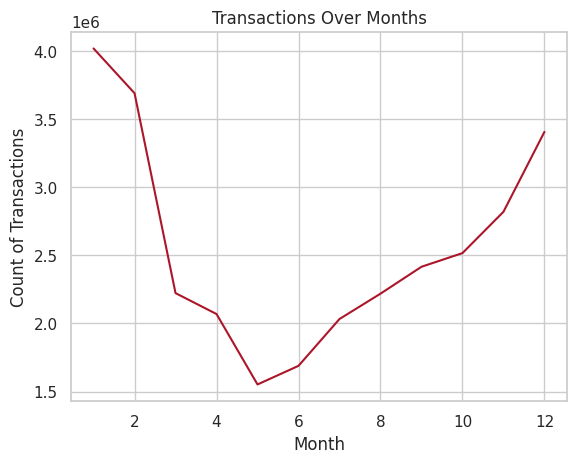

In [ ]:
sns.lineplot(data=Most_Purchased_Month,x='purchase_date',y='card_id')
plt.title('Transactions Over Months')
plt.xlabel('Month')
plt.ylabel('Count of Transactions')
plt.show()

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Distribution of Purchased Amount</b>

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



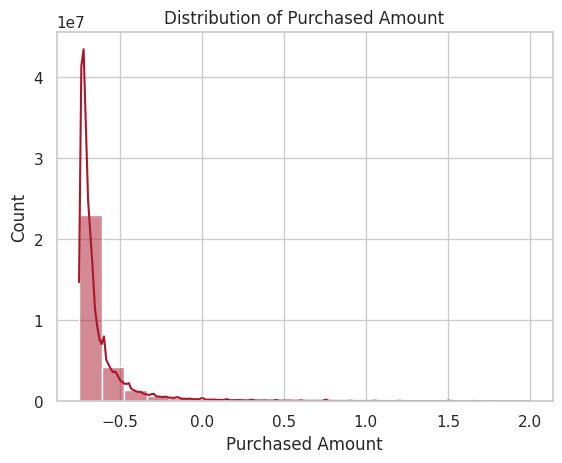

In [ ]:
sns.histplot(data=combined_transactions,x='purchase_amount',kde=True,bins=20)
plt.title('Distribution of Purchased Amount')
plt.xlabel('Purchased Amount')
plt.show()

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Feature Encoding</b>

In [ ]:
# Encode categorical features to numerical

combined_transactions['authorized_flag'] = combined_transactions['authorized_flag'].map({'Y': 1 , 'N': 0})
combined_transactions['category_1'] = combined_transactions['category_1'].map({'Y': 1 , 'N': 0})
combined_transactions['category_3'] = combined_transactions['category_3'].map({'A': 1 , 'B': 2 , 'C': 3})

<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Feature Engineering</b>

In [ ]:
# Extract the year from 'purchase_date' column and create 'purchase_year' column

combined_transactions['purchase_year'] = combined_transactions['purchase_date'].dt.year

In [ ]:
# Extract the month from 'purchase_date' column and create 'purchase_month' column


combined_transactions['purchase_month'] = combined_transactions['purchase_date'].dt.month

In [ ]:
# Extract the day from 'purchase_date' column and create 'purchase_day' column


combined_transactions['purchase_day'] = combined_transactions['purchase_date'].dt.day

In [ ]:
# Extract the day of week from 'purchase_date' column and create 'purchase_dow' column


combined_transactions['purchase_dow'] = combined_transactions['purchase_date'].dt.day_of_week

In [ ]:
# Extract the hour from 'purchase_date' column and create 'purchase_hour' column


combined_transactions['purchase_hour'] = combined_transactions['purchase_date'].dt.hour

In [ ]:
# Create 'is_weekend' column: 1 if 'purchase_dow' is Saturday (5) or Sunday (6), 0 otherwise

combined_transactions['is_weekend'] = np.where(combined_transactions['purchase_dow'].isin([5, 6]), 1, 0)

In [ ]:
# Define time intervals based on the 'purchase_hour' column to Create 'purchase_at' column

time_day = [
    (combined_transactions['purchase_hour'] >= 6) & (combined_transactions['purchase_hour'] < 12),
    (combined_transactions['purchase_hour'] >= 12) & (combined_transactions['purchase_hour'] < 15),
    (combined_transactions['purchase_hour'] >= 15) & (combined_transactions['purchase_hour'] < 18),
    (combined_transactions['purchase_hour'] >= 18) & (combined_transactions['purchase_hour'] < 24)
]

In [ ]:
# Define labels for different time periods of the day

purchase_at = ['Morning', 'Noon', 'Afternoon', 'Evening']

# Create 'purchase_at' column based on 'time_day' conditions and 'purchase_at' labels

combined_transactions['purchase_at'] = np.select(time_day, purchase_at, default='Night')

In [ ]:
# Get today's date

today = np.datetime64(datetime.today())

In [ ]:
# Calculate the difference in days between today and 'purchase_date'

days_difference = (today - combined_transactions['purchase_date'].values).astype('timedelta64[D]').astype(int)

In [ ]:
# Calculate the months difference, assuming 30 days per month

combined_transactions['month_difference'] = (days_difference // 30).astype('int16')

In [ ]:
# Adjust 'month_difference' by substracting 'month_lag'

combined_transactions['month_difference'] = combined_transactions['month_difference'] - combined_transactions['month_lag']

In [ ]:
# Convert 'purchase_date' column to datetime objects

combined_transactions['purchase_date'] = pd.to_datetime(combined_transactions['purchase_date'])

In [ ]:
# Display the first rows of the Data

pd.set_option('display.max_columns', None)
combined_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_year,purchase_month,purchase_day,purchase_dow,purchase_hour,is_weekend,purchase_at,month_difference
0,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,2017,6,25,6,15,1,Afternoon,102
1,1,C_ID_4e6213e9bc,88,0,0,1,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2017,7,15,5,12,1,Noon,100
2,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2017,8,9,2,22,0,Evening,98
3,1,C_ID_4e6213e9bc,88,0,0,1,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,2017,9,2,5,10,1,Morning,97
4,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,2017,3,10,4,1,0,Night,108


<div style="padding:10px;
            color:#E55604;
            margin:10px;
            font-size:130%;
            display:fill;
            border-radius:5px;
            border-style: solid;
            border-color: #FF9B50;
            background-color:#000000;
            overflow:hidden;
            font-weight:400"><b>Features Aggregation</b>

In [ ]:
# Create Aggregation dictionary to define how to aggregate columns

aggregate_tbl = {
    'purchase_date':['min','max'],
    'purchase_year': [statistics.mode],
    'purchase_month': ['mean',statistics.mode],
    'purchase_day': [statistics.mode],
    'purchase_dow': [statistics.mode],
    'purchase_hour': ['min','max',statistics.mode],
    'is_weekend': ['mean','sum',statistics.mode],
    'month_difference': ['sum','mean','min','max']
    }


In [ ]:
# Group the 'combined_transactions' by 'card_id' and apply the aggregations

aggregate_purchase_date = combined_transactions.groupby('card_id').agg(aggregate_tbl).reset_index()
aggregate_purchase_date.head()

card_id       purchase_date                     purchase_year  \
                                   min                 max          mode   
0  C_ID_00007093c1 2017-02-14 14:00:43 2018-04-09 16:23:59          2017   
1  C_ID_0001238066 2017-09-28 22:25:14 2018-04-30 19:57:30          2017   
2  C_ID_0001506ef0 2017-01-14 16:16:01 2018-03-22 09:14:30          2017   
3  C_ID_0001793786 2017-01-21 10:15:21 2017-12-31 17:35:56          2017   
4  C_ID_000183fdda 2017-08-07 09:49:14 2018-04-26 13:46:18          2017   

  purchase_month      purchase_day purchase_dow purchase_hour           \
            mean mode         mode         mode           min max mode   
0       6.344371    6            8            0             0  22   16   
1       6.758621   12           24            5             0  23   19   
2       6.691176   12            6            5             0  22   12   
3       7.237500    9           14            3             0  23   15   
4       6.748299    2            8            2             0  23   22   

  is_weekend          month_difference                      
        mean sum mode              sum       mean min  max  
0   0.165563  25    0            14757  97.728477  82  110  
1   0.434483  63    0            12857  88.668966  82   96  
2   0.470588  32    0             6494  95.500000  84  112  
3   0.212500  51    0            22959  95.662500  86  108  
4   0.238095  35    0            13332  90.693878  82   98

In [ ]:
# Rename the columns of the aggregated Dataframe with 'trans_' prefix and concatenated column names

aggregate_purchase_date.columns = ['trans_'+'_'.join(col).strip() for col in aggregate_purchase_date.columns.values]
aggregate_purchase_date = aggregate_purchase_date.rename(columns={'trans_card_id_':'card_id'})
aggregate_purchase_date.head()

,card_id,trans_purchase_date_min,trans_purchase_date_max,trans_purchase_year_mode,trans_purchase_month_mean,trans_purchase_month_mode,trans_purchase_day_mode,trans_purchase_dow_mode,trans_purchase_hour_min,trans_purchase_hour_max,trans_purchase_hour_mode,trans_is_weekend_mean,trans_is_weekend_sum,trans_is_weekend_mode,trans_month_difference_sum,trans_month_difference_mean,trans_month_difference_min,trans_month_difference_max
0,C_ID_00007093c1,2017-02-14 14:00:43,2018-04-09 16:23:59,2017,6.344371,6,8,0,0,22,16,0.165563,25,0,14757,97.728477,82,110
1,C_ID_0001238066,2017-09-28 22:25:14,2018-04-30 19:57:30,2017,6.758621,12,24,5,0,23,19,0.434483,63,0,12857,88.668966,82,96
2,C_ID_0001506ef0,2017-01-14 16:16:01,2018-03-22 09:14:30,2017,6.691176,12,6,5,0,22,12,0.470588,32,0,6494,95.500000,84,112
3,C_ID_0001793786,2017-01-21 10:15:21,2017-12-31 17:35:56,2017,7.237500,9,14,3,0,23,15,0.212500,51,0,22959,95.662500,86,108
4,C_ID_000183fdda,2017-08-07 09:49:14,2018-04-26 13:46:18,2017,6.748299,2,8,2,0,23,22,0.238095,35,0,13332,90.693878,82,98


In [ ]:
# Calculate the number of days since the first and last transactions for each card_id

aggregate_purchase_date['first_transaction'] = (datetime.today() - aggregate_purchase_date['trans_purchase_date_min']).dt.days
aggregate_purchase_date['last_transaction'] = (datetime.today() - aggregate_purchase_date['trans_purchase_date_max']).dt.days

In [ ]:
# Intialize OneHotEncoder to convert categorical 'purchase_at' to numerical feature

encoder = OneHotEncoder()
one_hot = encoder.fit_transform(combined_transactions[['purchase_at']])

In [ ]:
# Create Dataframe from the one-hot encoded array with feature names

df = pd.DataFrame(one_hot.toarray(),columns=encoder.get_feature_names_out())
df.head()

,purchase_at_Afternoon,purchase_at_Evening,purchase_at_Morning,purchase_at_Night,purchase_at_Noon
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Reset the index of combined_transactions
combined_transactions = combined_transactions.reset_index(drop=True)

#Reset index of df
df = df.reset_index(drop=True)

# Concatenate the 'combined_transactions' DataFrame with the one-hot encoded DataFrame
combined_transactions = pd.concat([combined_transactions, df], axis=1)
combined_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_year,purchase_month,purchase_day,purchase_dow,purchase_hour,is_weekend,purchase_at,month_difference,purchase_at_Afternoon,purchase_at_Evening,purchase_at_Morning,purchase_at_Night,purchase_at_Noon
0,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,2017,6,25,6,15,1,Afternoon,102,1.0,0.0,0.0,0.0,0.0
1,1,C_ID_4e6213e9bc,88,0,0,1,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2017,7,15,5,12,1,Noon,100,0.0,0.0,0.0,0.0,1.0
2,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2017,8,9,2,22,0,Evening,98,0.0,1.0,0.0,0.0,0.0
3,1,C_ID_4e6213e9bc,88,0,0,1,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,2017,9,2,5,10,1,Morning,97,0.0,0.0,1.0,0.0,0.0
4,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,2017,3,10,4,1,0,Night,108,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Group the 'combined_transactions' DataFrame by 'card_id' and aggregate 'purchase_amount'

aggregate_purchase_amount = combined_transactions.groupby('card_id')['purchase_amount'].agg(['sum','max','min','mean','median']).reset_index()
aggregate_purchase_amount.head()

,card_id,sum,max,min,mean,median
0,C_ID_00007093c1,-78.173561,1.507069,-0.728876,-0.517706,-0.596447
1,C_ID_0001238066,-86.623604,0.768095,-0.740897,-0.597404,-0.650693
2,C_ID_0001506ef0,-36.049232,1.493545,-0.740491,-0.530136,-0.706036
3,C_ID_0001793786,-61.026840,1.935775,-0.745405,-0.254279,-0.486070
4,C_ID_000183fdda,-77.889786,1.905121,-0.737892,-0.529862,-0.671775


In [ ]:
# Rename the columns of the 'aggregate_purchase_amount' DataFrame

aggregate_purchase_amount.columns = ['trans_purchase_amount_'+''.join(col).strip() for col in aggregate_purchase_amount.columns.values]
aggregate_purchase_amount = aggregate_purchase_amount.rename(columns={'trans_purchase_amount_card_id':'card_id'})
aggregate_purchase_amount.head()

,card_id,trans_purchase_amount_sum,trans_purchase_amount_max,trans_purchase_amount_min,trans_purchase_amount_mean,trans_purchase_amount_median
0,C_ID_00007093c1,-78.173561,1.507069,-0.728876,-0.517706,-0.596447
1,C_ID_0001238066,-86.623604,0.768095,-0.740897,-0.597404,-0.650693
2,C_ID_0001506ef0,-36.049232,1.493545,-0.740491,-0.530136,-0.706036
3,C_ID_0001793786,-61.026840,1.935775,-0.745405,-0.254279,-0.486070
4,C_ID_000183fdda,-77.889786,1.905121,-0.737892,-0.529862,-0.671775


In [ ]:
# Define an aggregation dictionary

aggregate_tbl2 = {
    'authorized_flag': ['sum','mean'],
    'city_id': [statistics.mode,'nunique'],
    'category_1': ['sum','mean',statistics.mode],
    'category_2': ['sum','mean',statistics.mode],
    'category_3': ['sum','mean',statistics.mode],
    'installments': ['mean','sum','min','max',statistics.mode],
    'merchant_category_id': [statistics.mode,'nunique'],
    'merchant_id': [statistics.mode,'nunique'],
    'state_id': [statistics.mode,'nunique'],
    'subsector_id': ['nunique',statistics.mode],
    'purchase_at_Afternoon': [statistics.mode,'sum','mean'],
    'purchase_at_Evening': [statistics.mode,'sum','mean'],
    'purchase_at_Morning': [statistics.mode,'sum','mean'],
    'purchase_at_Night': [statistics.mode,'sum','mean'],
    'purchase_at_Noon': [statistics.mode,'sum','mean']
}

In [ ]:
# Dropping 'purchase_at' column

combined_transactions = combined_transactions.drop(columns='purchase_at',axis=1)

In [ ]:
# Convert category columns to object

combined_transactions['category_1'] = combined_transactions['category_1'].astype('object')
combined_transactions['category_3'] = combined_transactions['category_3'].astype('object')

In [ ]:
# Group 'combined_transactions' by 'card_id' and apply aggregations defined

aggregate_features = combined_transactions.groupby('card_id').agg(aggregate_tbl2).reset_index()
aggregate_features.head()

card_id authorized_flag           city_id         category_1  \
                               sum      mean    mode nunique        sum   
0  C_ID_00007093c1             116  0.768212     244       5         28   
1  C_ID_0001238066             142  0.979310     314      18          4   
2  C_ID_0001506ef0              64  0.941176     137       3          0   
3  C_ID_0001793786             213  0.887500     179      11          2   
4  C_ID_000183fdda             140  0.952381     161       9          4   

                 category_2                category_3                 \
       mean mode        sum      mean mode        sum      mean mode   
0   0.18543    0      397.0  2.629139  3.0        326   2.15894    2   
1  0.027586    0      233.0  1.606897  1.0        326  2.248276    2   
2       0.0    0      200.0  2.941176  3.0         69  1.014706    1   
3  0.008333    0      366.0  1.525000  1.0        245  1.020833    1   
4  0.027211    0      420.0  2.857143  3.0        332  2.258503    2   

  installments                   merchant_category_id          \
          mean  sum min max mode                 mode nunique   
0     1.284768  194   1   6    1                  307      19   
1     1.682759  244   1  10    1                  307      33   
2     0.014706    1   0   1    0                  705      20   
3     0.020833    5   0   1    0                  278      55   
4     1.843537  271   1  10    1                  367      36   

       merchant_id         state_id         subsector_id       \
              mode nunique     mode nunique      nunique mode   
0  M_ID_9400cf2342      31        2       4           13   19   
1  M_ID_d17aabd756      86        9       5           18   19   
2  M_ID_b1fc88154d      29       19       2           12   33   
3  M_ID_923d57de8d     144       -1       5           25   37   
4  M_ID_f9cfe0a43b      79        3       6           20   16   

  purchase_at_Afternoon                 purchase_at_Evening                  \
                   mode   sum      mean                mode   sum      mean   
0                   0.0  49.0  0.324503                 0.0  37.0  0.245033   
1                   0.0  27.0  0.186207                 0.0  57.0  0.393103   
2                   0.0  14.0  0.205882                 0.0   4.0  0.058824   
3                   0.0  62.0  0.258333                 0.0  83.0  0.345833   
4                   0.0  22.0  0.149660                 1.0  77.0  0.523810   

  purchase_at_Morning                 purchase_at_Night                  \
                 mode   sum      mean              mode   sum      mean   
0                 0.0  36.0  0.238411               0.0   5.0  0.033113   
1                 0.0  16.0  0.110345               0.0  15.0  0.103448   
2                 0.0  18.0  0.264706               0.0   1.0  0.014706   
3                 0.0  31.0  0.129167               0.0  12.0  0.050000   
4                 0.0  14.0  0.095238               0.0   7.0  0.047619   

  purchase_at_Noon                  
              mode   sum      mean  
0              0.0  24.0  0.158940  
1              0.0  30.0  0.206897  
2              0.0  31.0  0.455882  
3              0.0  52.0  0.216667  
4              0.0  27.0  0.183673

In [ ]:
# Rename the columns of the 'aggregate_features' DataFrame

aggregate_features.columns = [str(uppers)+'_'+str(lowers) for uppers, lowers in aggregate_features.columns.values]
aggregate_features.head()

,card_id_,authorized_flag_sum,authorized_flag_mean,city_id_mode,city_id_nunique,category_1_sum,category_1_mean,category_1_mode,category_2_sum,category_2_mean,category_2_mode,category_3_sum,category_3_mean,category_3_mode,installments_mean,installments_sum,installments_min,installments_max,installments_mode,merchant_category_id_mode,merchant_category_id_nunique,merchant_id_mode,merchant_id_nunique,state_id_mode,state_id_nunique,subsector_id_nunique,subsector_id_mode,purchase_at_Afternoon_mode,purchase_at_Afternoon_sum,purchase_at_Afternoon_mean,purchase_at_Evening_mode,purchase_at_Evening_sum,purchase_at_Evening_mean,purchase_at_Morning_mode,purchase_at_Morning_sum,purchase_at_Morning_mean,purchase_at_Night_mode,purchase_at_Night_sum,purchase_at_Night_mean,purchase_at_Noon_mode,purchase_at_Noon_sum,purchase_at_Noon_mean
0,C_ID_00007093c1,116,0.768212,244,5,28,0.18543,0,397.0,2.629139,3.0,326,2.15894,2,1.284768,194,1,6,1,307,19,M_ID_9400cf2342,31,2,4,13,19,0.0,49.0,0.324503,0.0,37.0,0.245033,0.0,36.0,0.238411,0.0,5.0,0.033113,0.0,24.0,0.158940
1,C_ID_0001238066,142,0.979310,314,18,4,0.027586,0,233.0,1.606897,1.0,326,2.248276,2,1.682759,244,1,10,1,307,33,M_ID_d17aabd756,86,9,5,18,19,0.0,27.0,0.186207,0.0,57.0,0.393103,0.0,16.0,0.110345,0.0,15.0,0.103448,0.0,30.0,0.206897
2,C_ID_0001506ef0,64,0.941176,137,3,0,0.0,0,200.0,2.941176,3.0,69,1.014706,1,0.014706,1,0,1,0,705,20,M_ID_b1fc88154d,29,19,2,12,33,0.0,14.0,0.205882,0.0,4.0,0.058824,0.0,18.0,0.264706,0.0,1.0,0.014706,0.0,31.0,0.455882
3,C_ID_0001793786,213,0.887500,179,11,2,0.008333,0,366.0,1.525000,1.0,245,1.020833,1,0.020833,5,0,1,0,278,55,M_ID_923d57de8d,144,-1,5,25,37,0.0,62.0,0.258333,0.0,83.0,0.345833,0.0,31.0,0.129167,0.0,12.0,0.050000,0.0,52.0,0.216667
4,C_ID_000183fdda,140,0.952381,161,9,4,0.027211,0,420.0,2.857143,3.0,332,2.258503,2,1.843537,271,1,10,1,367,36,M_ID_f9cfe0a43b,79,3,6,20,16,0.0,22.0,0.149660,1.0,77.0,0.523810,0.0,14.0,0.095238,0.0,7.0,0.047619,0.0,27.0,0.183673


In [ ]:
# Concatenate 'aggregate_purchase_date', 'aggregate_purchase_amount' and 'aggregate_features'

aggregate_transactions = pd.concat([aggregate_purchase_date,aggregate_purchase_amount,aggregate_features],axis=1)

In [ ]:
# Display the number of rows and columns of 'aggregate_transactions'

aggregate_transactions.shape

(325526, 68)

In [ ]:
# Checking the number of null values in the 'aggregate_transactions' DataFrame

aggregate_transactions.isnull().sum().sum()

0

In [ ]:
# Perform garbage collection to free up memory

gc.collect()

671

In [ ]:
# Save the 'aggregate_transactions' DataFrame to CSV file without the Index
aggregate_transactions.to_csv('/content/drive/MyDrive/ColabNotebooks/aggregate_transactions.csv', index=False)

print("aggregate_transactions saved")

aggregate_transactions saved to /kaggle/working/aggregate_transactions.csv
